# Read in the data

In [225]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [226]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [227]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [228]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [229]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [230]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [231]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [232]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [233]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [234]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

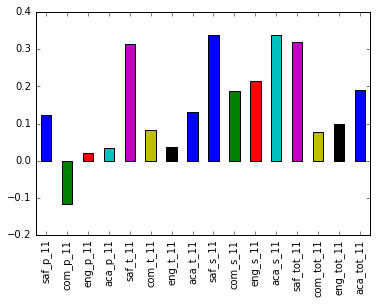

In [235]:
combined.corr()["sat_score"][survey_fields].plot.bar()

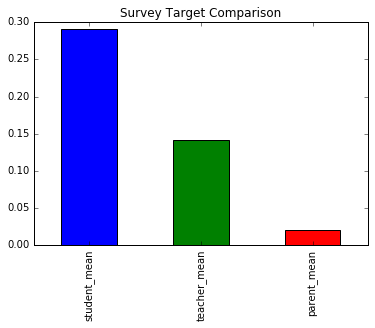

In [236]:
student_cols = [col for col in combined.columns if '_s_11' in col]
teacher_cols = [col for col in combined.columns if '_t_11' in col]
parent_cols = [col for col in combined.columns if '_p_11' in col]

combined['student_mean'] = combined[student_cols].mean(axis=1)
combined['teacher_mean'] = combined[teacher_cols].mean(axis=1)
combined['parent_mean'] = combined[parent_cols].mean(axis=1)

combined.corr()["sat_score"][['student_mean','teacher_mean','parent_mean']].plot.bar(title='Survey Target Comparison')


Positive responses from students are much more highly correlated than parent and teacher responses.

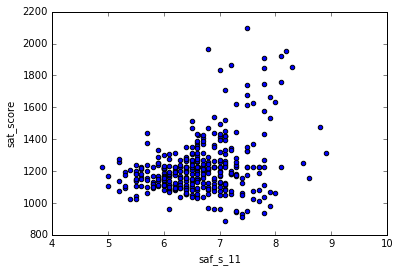

In [237]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

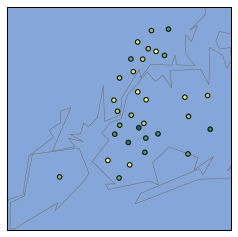

In [238]:
# compute the average safety score for each district
safety_by_district = combined.groupby('school_dist')[['saf_s_11','lat','lon','sat_score']].agg(np.mean).reset_index()
latitudes = safety_by_district['lat'].tolist()
longitudes = safety_by_district['lon'].tolist()

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i')
m.drawmapboundary(fill_color='#85a6d9')
m.drawcoastlines(color='#6d5f47', linewidth=.4)
m.drawrivers(color='#6d5f47', linewidth=.4)
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=safety_by_district['saf_s_11'], cmap='summer')

# Investigate racial differences in SAT scores

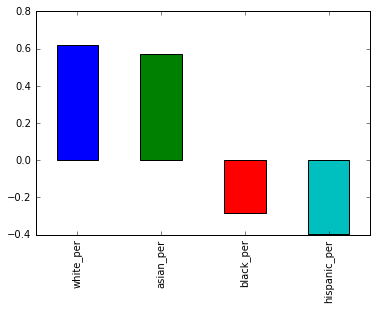

In [239]:
race_cols = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][race_cols].plot.bar()

Blacks and Hispanics have the lowest SAT scores... but why?

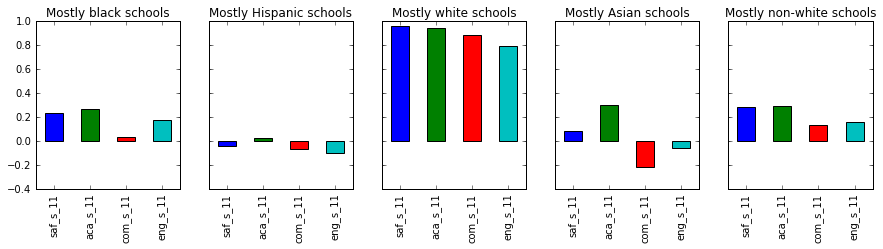

In [240]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3), sharey=True)
xlabels = ['saf_s_11','aca_s_11','com_s_11','eng_s_11']

def plot_correlations(index, df, title):
    race_correlations = df.corr()["sat_score"][xlabels]
    race_correlations.plot.bar(ax=axes[index], title=title)

plot_correlations(0, combined[combined.black_per > 50], 'Mostly black schools')
plot_correlations(1, combined[combined.hispanic_per > 50], 'Mostly Hispanic schools')
plot_correlations(2, combined[combined.white_per > 50], 'Mostly white schools')
plot_correlations(3, combined[combined.asian_per > 50], 'Mostly Asian schools')
plot_correlations(4, combined[combined.white_per < 50], 'Mostly non-white schools')


In mostly white schools, the survey results are a strong predictor of SAT scores, but were a non-factor in other schools.

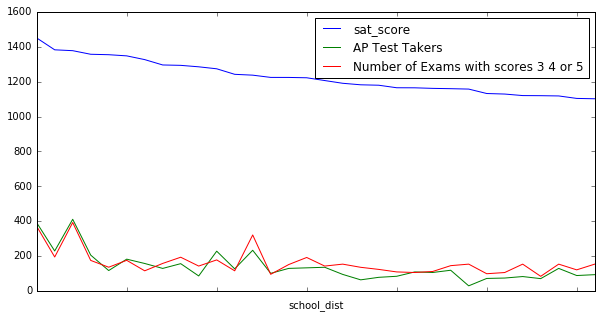

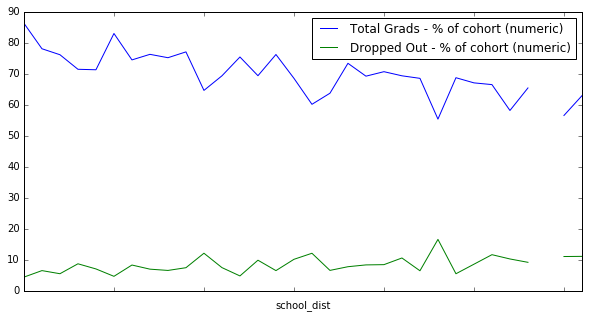

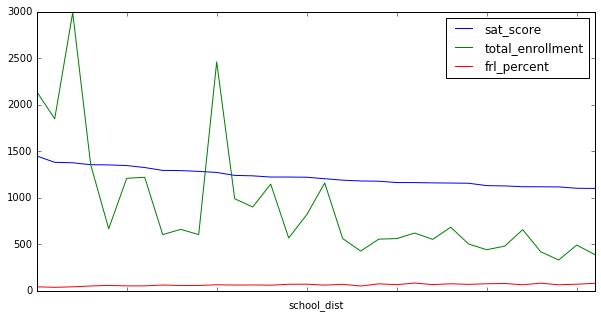

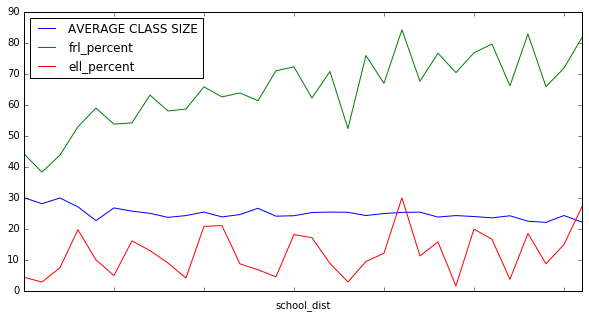

In [254]:
# What are the demographics of school districts with high test scores?

def convert_percentage(old_key, new_key):
    combined[new_key] = pd.to_numeric(combined[old_key].str.replace('%',''), errors='coerce')

convert_percentage("Total Grads - % of cohort", "Total Grads - % of cohort (numeric)")
convert_percentage("Dropped Out - % of cohort", "Dropped Out - % of cohort (numeric)")

school_districts = combined[['DBN','SCHOOL NAME', 'Num of SAT Test Takers', 'sat_score', 'AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5', 'Total Grads - % of cohort (numeric)', 'Dropped Out - % of cohort (numeric)', 'AVERAGE CLASS SIZE', 'frl_percent', 'total_enrollment', 'ell_percent', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'school_dist']] \
    .groupby('school_dist').agg(np.mean).reset_index().sort_values('sat_score', ascending=False)

def plot_factors(columns):    
    school_districts[columns + ['school_dist']].plot.line(x='school_dist', figsize=(10,5))
    
plot_factors(['sat_score', 'AP Test Takers ', 'Number of Exams with scores 3 4 or 5'])
plot_factors(["Total Grads - % of cohort (numeric)", "Dropped Out - % of cohort (numeric)"])
plot_factors(['sat_score', 'total_enrollment'])
plot_factors(['AVERAGE CLASS SIZE', 'frl_percent', 'ell_percent'])

School districts with more AP classes, higher graduation rates, and higher total enrollment generally do better on SAT tests.  Foreign language students do significantly worse.  Total enrollment doesn't make sense as a direct predictor of success.

correlation between enrollment and foreign language: -0.6572548899730897


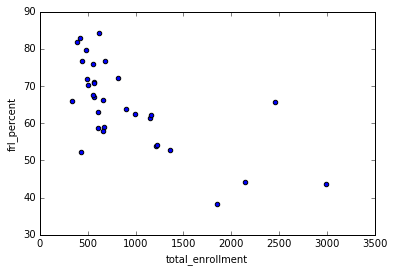

In [263]:
school_districts.plot.scatter(x='total_enrollment', y='frl_percent')
print('correlation between enrollment and foreign language: ' + str(school_districts.corr()['total_enrollment']['frl_percent']))

Schools that focus on serving international students will likely be smaller.  Therefore, total enrollment is not a good predictor of success, the foreign language factor is what's important.  Let's see what happens when we graph correlation of survey results for primarily English speaking schools.

Mostly black schools - 7 rows
Mostly Hispanic schools - 3 rows
Mostly white schools - 11 rows
Mostly Asian schools - 4 rows
Mostly non-white schools - 41 rows


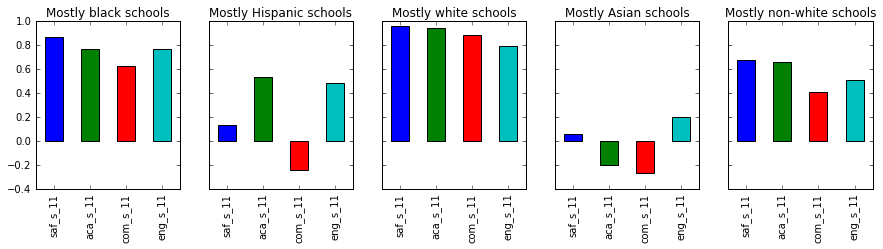

In [270]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3), sharey=True)
xlabels = ['saf_s_11','aca_s_11','com_s_11','eng_s_11']

def plot_correlations(index, df, title):
    print(title + ' - ' + str(df.shape[0]) + ' rows')
    race_correlations = df.corr()["sat_score"][xlabels]
    race_correlations.plot.bar(ax=axes[index], title=title)

english_speaking = combined[combined.frl_percent < 50]    
plot_correlations(0, english_speaking[english_speaking.black_per > 50], 'Mostly black schools')
plot_correlations(1, english_speaking[english_speaking.hispanic_per > 50], 'Mostly Hispanic schools')
plot_correlations(2, english_speaking[english_speaking.white_per > 50], 'Mostly white schools')
plot_correlations(3, english_speaking[english_speaking.asian_per > 50], 'Mostly Asian schools')
plot_correlations(4, english_speaking[english_speaking.white_per < 50], 'Mostly non-white schools')

When we exclude schools with a high percentage of foreign students, the survey results are a much better predictor or test scores in both primarily white and primarily non-white schools.  The correlation is much more positive for black schools with the foreign language schools excluded.

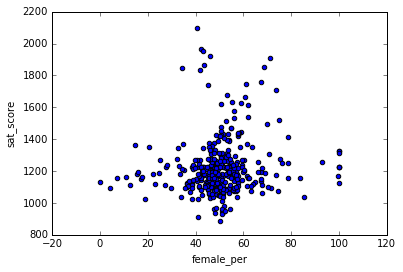

In [117]:
combined.plot.scatter(x='female_per',y='sat_score')

Females in mixed gender schools seem to do the best, but the general correlation is weak.

In [118]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

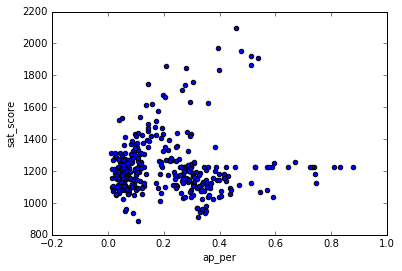

In [120]:
combined.plot.scatter(x='ap_per',y='sat_score')

In [124]:
combined.corr()['sat_score']['ap_per']

0.05717081390766967

In [125]:
# is there a correlation between good SAT scores and AP classes?
combined[combined['sat_score'] > 1600].corr()['sat_score']['ap_per']

0.7263717628372337

There is a very strong correlation between AP classes and good SAT scores.

# Overall Conclusions

These appear to be the biggest factors in schools with good test scores:
* Schools with large populations of foreign language speaking students had significantly lower scores.
* Students that feel that they have acacdemic expectations, safety, and respect have higher test scores
* In schools with good test scores, 